In [1]:
import sys
from pathlib import Path
import importlib
import warnings

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

warnings.filterwarnings('ignore')

PROJECT_ROOT = Path.cwd().resolve().parent if Path.cwd().name == 'analyses' else Path.cwd().resolve()
ANALYSES_DIR = PROJECT_ROOT / 'analyses'
OUT_DIR = ANALYSES_DIR / 'results'
OUT_DIR.mkdir(parents=True, exist_ok=True)

if str(PROJECT_ROOT) not in sys.path:
    sys.path.insert(0, str(PROJECT_ROOT))

from src.evaluation import dual_loss_with_rl as runner
runner = importlib.reload(runner)

print('Project root:', PROJECT_ROOT)
print('Output dir:', OUT_DIR)
print('Runner:', runner.__file__)


Project root: /home/clayt/Ensemble-Forecasting
Output dir: /home/clayt/Ensemble-Forecasting/analyses/results
Runner: /home/clayt/Ensemble-Forecasting/src/evaluation/dual_loss_with_rl.py


## Configuration


In [2]:
SCENARIO = 'discriminating'
HORIZONS = [1, 4, 8]
T = 1400
WINDOW = 150

TUNING_SEEDS = [0, 1, 2, 3]
TEST_SEEDS = [4, 5, 6, 7, 8, 9]
N_TRIALS = 35

# Set False only if optuna is installed and you want to re-tune from scratch.
USE_EXISTING_TUNING = True
TUNED_PARAMS_CSV = OUT_DIR / 'dual_loss_full_tuned_params.csv'

LINEX_A = 1.0
KAPPA_GRID = np.array([0.01, 0.03, 0.1, 0.3, 1.0, 3.0, 8.0], dtype=float)

LOSS_SECTIONS = [('mse', 'squared', 'mse'), ('linex', 'linex', 'linex')]
METHODS = list(runner.ot.DEFAULT_METHOD_PARAMS.keys())

print('Methods:', METHODS)
print('Use existing tuning:', USE_EXISTING_TUNING)
print('Tuned params CSV:', TUNED_PARAMS_CSV)


Methods: ['Mean', 'Median', 'OGDVanilla', 'MWUMVanilla', 'OGDBoth', 'OGDConcOnly', 'MWUMBothKL', 'MWUMConcOnlyKL']


## Tune Regular Methods By Horizon (Both Loss Sections)


In [3]:
tuning_rows = []
tuned_by_loss_h = {}

if USE_EXISTING_TUNING:
    tuning_rows, tuned_by_loss_h = runner.load_tuned_params_from_csv(
        csv_path=TUNED_PARAMS_CSV,
        horizons=HORIZONS,
        methods=METHODS,
    )
    tuning_df = pd.DataFrame(tuning_rows).sort_values(['loss_section', 'horizon', 'method']).reset_index(drop=True)
    print(f'Loaded tuned parameters from: {TUNED_PARAMS_CSV}')
else:
    for loss_section, ens_loss, objective_metric in LOSS_SECTIONS:
        tuned_by_h = {}
        print(f'\n=== Tuning section: {loss_section.upper()} ===')
        for h in HORIZONS:
            slices_h = []
            for seed in TUNING_SEEDS:
                data_t, forecasts_t, _, s_unc_t = runner.simulator.make_environment_and_forecasts(
                    T=T, horizons=HORIZONS, window=WINDOW, seed=seed, include_oracle=False, scenario=SCENARIO
                )
                y_t, F_t, s_t = runner.align_for_horizon(data_t['pi'], forecasts_t[h], s_unc_t, h)
                slices_h.append((y_t, F_t, s_t))

            tuned_h = runner.ot.tune_all_methods_optuna(
                data_slices=slices_h,
                methods=METHODS,
                n_trials=N_TRIALS,
                seed=42 + 100 * h,
                loss=ens_loss,
                linex_a=LINEX_A,
                objective_metric=objective_metric,
            )

            tuned_by_h[h] = {m: dict(tuned_h[m].best_params) for m in METHODS}
            for m in METHODS:
                tuning_rows.append({
                    'loss_section': loss_section,
                    'horizon': float(h),
                    'method': m,
                    'best_params': str(tuned_h[m].best_params),
                    'tuning_objective': float(tuned_h[m].best_value),
                })

        tuned_by_loss_h[loss_section] = tuned_by_h

    tuning_df = pd.DataFrame(tuning_rows).sort_values(['loss_section', 'horizon', 'tuning_objective']).reset_index(drop=True)

display(tuning_df)



=== Tuning section: MSE ===


[I 2026-02-16 20:25:23,619] A new study created in memory with name: no-name-75fa9876-1822-4e6d-9908-23c56e30487a
[I 2026-02-16 20:25:23,625] A new study created in memory with name: no-name-f4e00953-170e-4a71-b9c0-836a3a18f308
[I 2026-02-16 20:25:23,629] A new study created in memory with name: no-name-bfcc4942-f701-407c-8b4b-38888d527f91
[I 2026-02-16 20:25:23,793] Trial 0 finished with value: 0.9750400010255719 and parameters: {'eta': 0.008116076157212304}. Best is trial 0 with value: 0.9750400010255719.
[I 2026-02-16 20:25:23,931] Trial 1 finished with value: 0.9527323640132535 and parameters: {'eta': 0.00347441289862208}. Best is trial 1 with value: 0.9527323640132535.
[I 2026-02-16 20:25:24,090] Trial 2 finished with value: 0.9709836686883979 and parameters: {'eta': 0.007124784397429192}. Best is trial 1 with value: 0.9527323640132535.
[I 2026-02-16 20:25:24,203] Trial 3 finished with value: 1.1729561371405237 and parameters: {'eta': 0.10030664921071857}. Best is trial 1 with val


=== Tuning section: LINEX ===


[I 2026-02-16 20:26:58,438] A new study created in memory with name: no-name-c4689099-eed7-402c-a024-59b8f502a71d
[I 2026-02-16 20:26:58,441] A new study created in memory with name: no-name-92e5f302-a38c-453c-a42b-a300c1ec6bfa
[I 2026-02-16 20:26:58,442] A new study created in memory with name: no-name-c138095d-2b24-401a-9f82-5f35da0adf09
[I 2026-02-16 20:26:58,513] Trial 0 finished with value: 2.4204162574635504 and parameters: {'eta': 0.008116076157212304}. Best is trial 0 with value: 2.4204162574635504.
[I 2026-02-16 20:26:58,586] Trial 1 finished with value: 2.2939481641653865 and parameters: {'eta': 0.00347441289862208}. Best is trial 1 with value: 2.2939481641653865.
[I 2026-02-16 20:26:58,659] Trial 2 finished with value: 2.3773246382880275 and parameters: {'eta': 0.007124784397429192}. Best is trial 1 with value: 2.2939481641653865.
[I 2026-02-16 20:26:58,726] Trial 3 finished with value: 3.0832774450336795 and parameters: {'eta': 0.10030664921071857}. Best is trial 1 with val

,loss_section,horizon,method,best_params,tuning_objective
0,linex,1.0,Mean,{},1.571689
1,linex,1.0,MWUMVanilla,{'eta': 0.001071380345127959},1.967996
2,linex,1.0,MWUMConcOnlyKL,{'kappa': 7.849943290518327},2.067145
3,linex,1.0,Median,{},2.139773
4,linex,1.0,MWUMBothKL,"{'eta': 2.659494788779418, 'kappa': 0.00115092...",2.151003
5,linex,1.0,OGDVanilla,{'eta': 0.0031709028216475085},2.291313
6,linex,1.0,OGDBoth,"{'eta': 0.00302272642675273, 'kappa': 0.003670...",2.291414
7,linex,1.0,OGDConcOnly,{'kappa': 7.989067040220606},2.808967
8,linex,4.0,OGDBoth,"{'eta': 0.03764200803282203, 'kappa': 2.841565...",5.329784
9,linex,4.0,MWUMConcOnlyKL,{'kappa': 3.0807731507848457},5.388545


## Evaluate On Test Seeds (Regular + RL Methods)


In [4]:
all_rows = []
all_diag_rows = []

for loss_section, _, _ in LOSS_SECTIONS:
    print(f'\n=== Evaluating section: {loss_section.upper()} ===')
    for seed in TEST_SEEDS:
        rows, diag_rows = runner.evaluate_one_seed(
            seed=seed,
            horizons=HORIZONS,
            T=T,
            window=WINDOW,
            scenario=SCENARIO,
            loss_section=loss_section,
            linex_a=LINEX_A,
            params_map_by_h=tuned_by_loss_h[loss_section],
            kappa_grid=KAPPA_GRID,
        )
        all_rows.extend(rows)
        all_diag_rows.extend(diag_rows)

summary_rows = runner.aggregate(all_rows)

detailed_df = pd.DataFrame(all_rows).sort_values(['loss_section', 'horizon', 'seed', 'method']).reset_index(drop=True)
summary_df = pd.DataFrame(summary_rows).sort_values(['loss_section', 'horizon', 'objective_mean']).reset_index(drop=True)
diag_df = pd.DataFrame(all_diag_rows).sort_values(['loss_section', 'horizon', 'seed', 'method', 't']).reset_index(drop=True)

print('Detailed rows:', len(detailed_df))
print('Summary rows:', len(summary_df))
print('Diagnostics rows:', len(diag_df))
display(summary_df)



=== Evaluating section: MSE ===

=== Evaluating section: LINEX ===
Detailed rows: 360
Summary rows: 60
Diagnostics rows: 73440


,loss_section,horizon,method,objective_mean,objective_std,mse_mean,mae_mean,linex_mean,avg_hhi_mean,avg_lambda_mean,avg_excess_objective_vs_best_individual,avg_improvement_pct_vs_best_individual,diag_main_mean,diag_aux_mean
0,linex,1.0,MWUMBothKL,0.681403,0.133753,0.926195,0.683332,0.681403,0.956427,0.000772,0.046815,-7.435557,NaN,NaN
1,linex,1.0,Mean,0.721882,0.154857,0.844159,0.632936,0.721882,0.055556,NaN,0.087293,-13.159159,NaN,NaN
2,linex,1.0,MWUMVanilla,0.723602,0.143041,0.832474,0.624188,0.723602,0.057969,NaN,0.089013,-13.736367,NaN,NaN
3,linex,1.0,RLRuleBandit,0.727310,0.143685,0.866314,0.639455,0.727310,0.180132,NaN,0.092721,-14.362753,3.333333,0.406373
4,linex,1.0,OGDBoth,0.733327,0.166704,0.908486,0.664527,0.733327,0.130181,0.002459,0.098739,-14.785958,NaN,NaN
5,linex,1.0,OGDVanilla,0.734742,0.167437,0.909153,0.664757,0.734742,0.132069,NaN,0.100153,-15.001265,NaN,NaN
6,linex,1.0,MWUMConcOnlyKL,0.738807,0.152245,0.851871,0.629763,0.738807,0.058637,5.257088,0.104219,-16.002098,NaN,NaN
7,linex,1.0,Median,0.740750,0.142846,0.831550,0.618771,0.740750,NaN,NaN,0.106161,-16.581762,NaN,NaN
8,linex,1.0,OGDConcOnly,0.820281,0.166564,0.891196,0.638925,0.820281,0.083611,5.350259,0.185693,-29.165180,NaN,NaN
9,linex,1.0,RLKappaBandit,0.880113,0.169076,0.916228,0.642117,0.880113,0.192683,1.090868,0.245524,-38.711474,1.608936,0.521078


## Save Outputs


In [5]:
detailed_csv = OUT_DIR / 'dual_loss_full_detailed.csv'
summary_csv = OUT_DIR / 'dual_loss_full_summary.csv'
tuning_csv = OUT_DIR / 'dual_loss_full_tuned_params.csv'
diag_csv = OUT_DIR / 'dual_loss_full_policy_diagnostics.csv'
report_md = OUT_DIR / 'dual_loss_full_report.md'

runner.write_csv(detailed_csv, detailed_df.to_dict(orient='records'))
runner.write_csv(summary_csv, summary_df.to_dict(orient='records'))
runner.write_csv(tuning_csv, tuning_df.to_dict(orient='records'))
runner.write_csv(diag_csv, diag_df.to_dict(orient='records'))
runner.write_report(report_md, summary_df.to_dict(orient='records'), tuning_df.to_dict(orient='records'), linex_a=LINEX_A)

print('Wrote:', detailed_csv)
print('Wrote:', summary_csv)
print('Wrote:', tuning_csv)
print('Wrote:', diag_csv)
print('Wrote:', report_md)


Wrote: /home/clayt/Ensemble-Forecasting/analyses/results/dual_loss_full_detailed.csv
Wrote: /home/clayt/Ensemble-Forecasting/analyses/results/dual_loss_full_summary.csv
Wrote: /home/clayt/Ensemble-Forecasting/analyses/results/dual_loss_full_tuned_params.csv
Wrote: /home/clayt/Ensemble-Forecasting/analyses/results/dual_loss_full_policy_diagnostics.csv
Wrote: /home/clayt/Ensemble-Forecasting/analyses/results/dual_loss_full_report.md


## Plot: Objective Comparison By Horizon


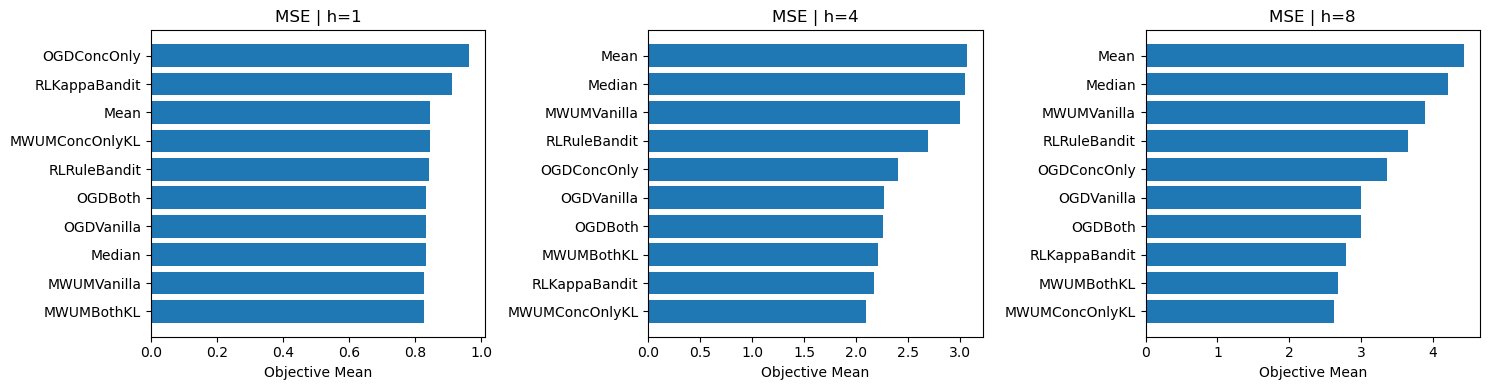

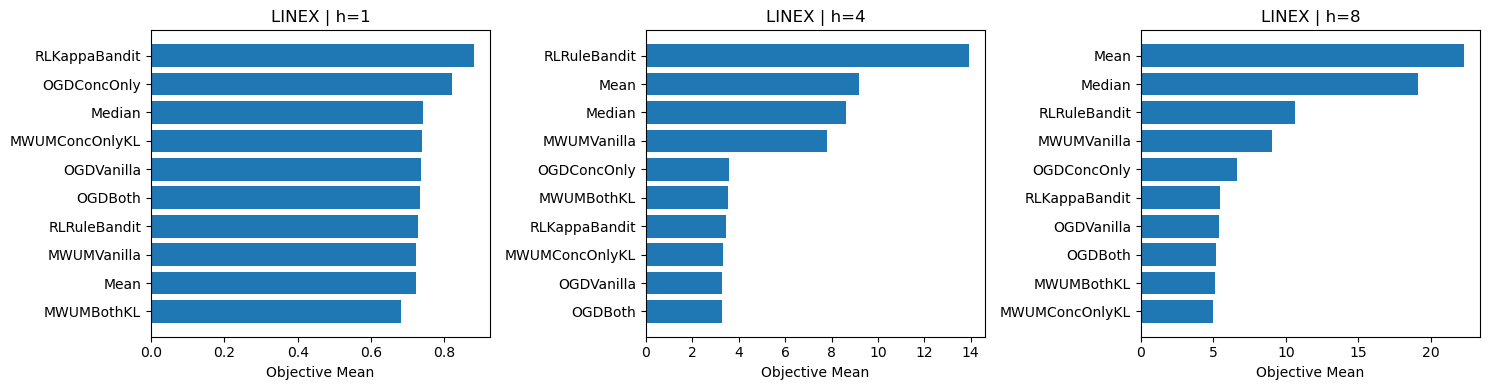

In [6]:
for loss_section in ['mse', 'linex']:
    fig, axes = plt.subplots(1, len(HORIZONS), figsize=(5 * len(HORIZONS), 4), sharey=False)
    if len(HORIZONS) == 1:
        axes = [axes]
    for ax, h in zip(axes, HORIZONS):
        sub = summary_df[(summary_df['loss_section'] == loss_section) & (summary_df['horizon'] == float(h))].copy()
        sub = sub.sort_values('objective_mean')
        ax.barh(sub['method'], sub['objective_mean'])
        ax.set_title(f'{loss_section.upper()} | h={h}')
        ax.set_xlabel('Objective Mean')
    plt.tight_layout()
    plt.show()


## Plot: Concentration (Average HHI)


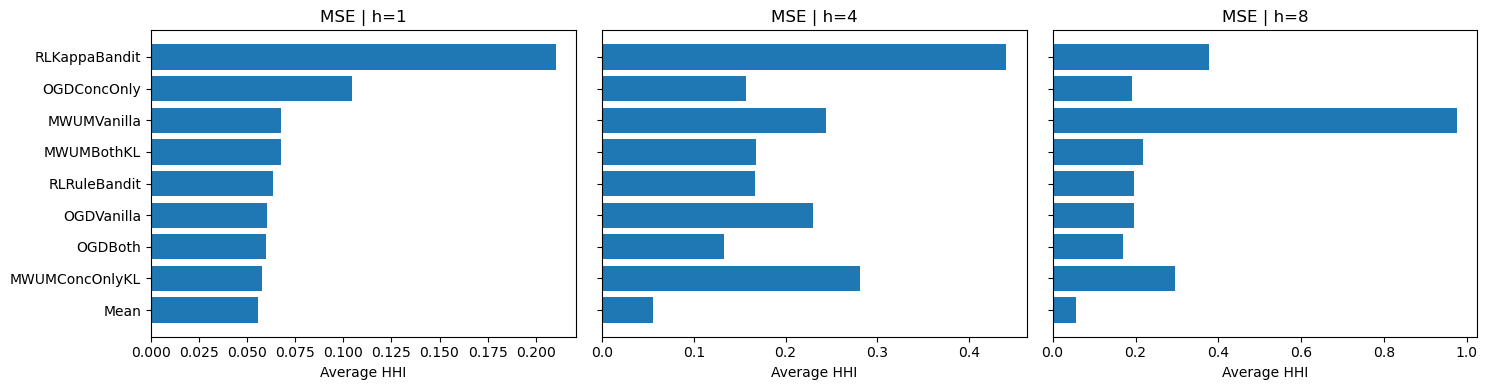

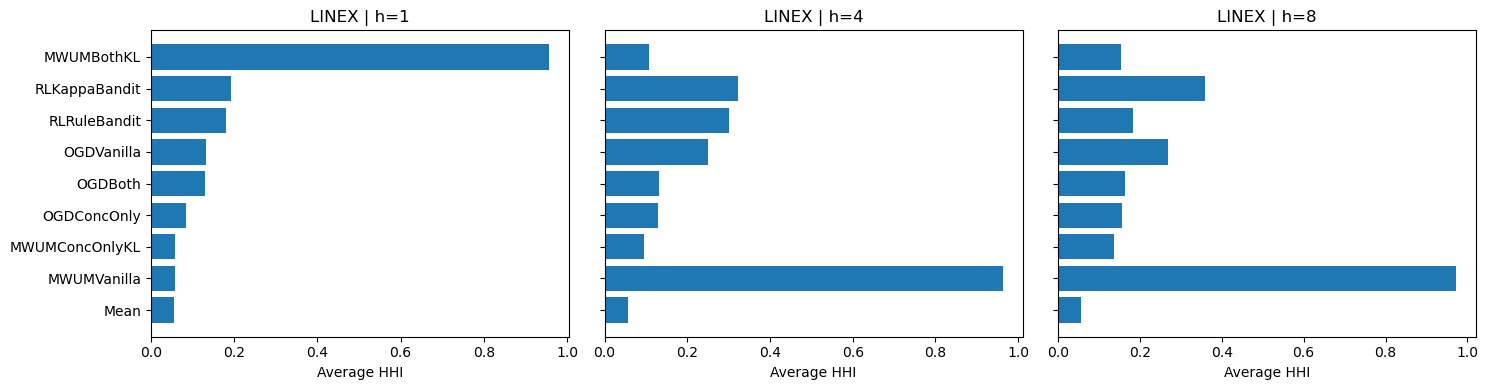

In [7]:
for loss_section in ['mse', 'linex']:
    fig, axes = plt.subplots(1, len(HORIZONS), figsize=(5 * len(HORIZONS), 4), sharey=True)
    if len(HORIZONS) == 1:
        axes = [axes]
    for ax, h in zip(axes, HORIZONS):
        sub = summary_df[(summary_df['loss_section'] == loss_section) & (summary_df['horizon'] == float(h))].copy()
        sub = sub.sort_values('avg_hhi_mean', na_position='last')
        ax.barh(sub['method'], sub['avg_hhi_mean'])
        ax.set_title(f'{loss_section.upper()} | h={h}')
        ax.set_xlabel('Average HHI')
    plt.tight_layout()
    plt.show()


## RL Diagnostics: Rule Selection Shares


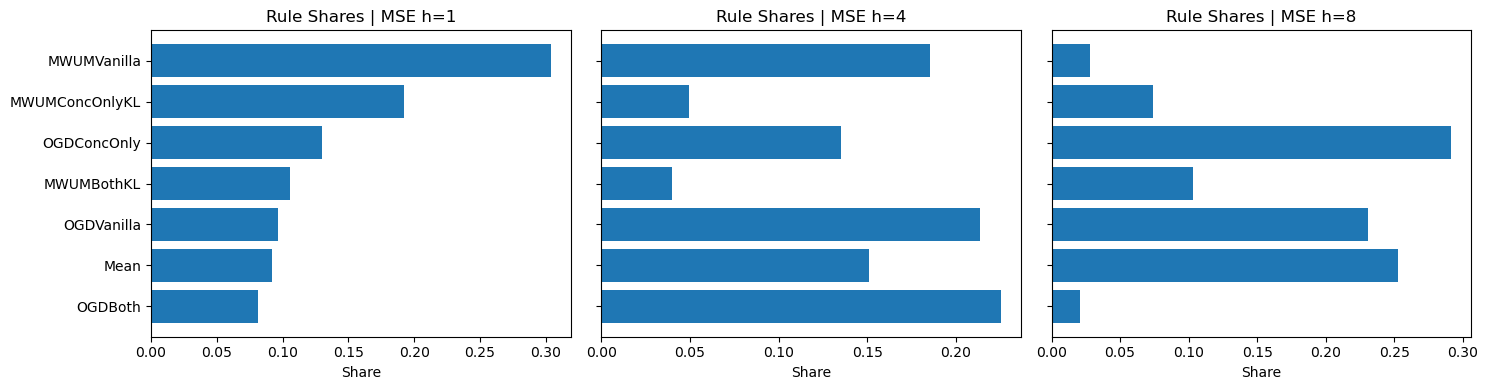

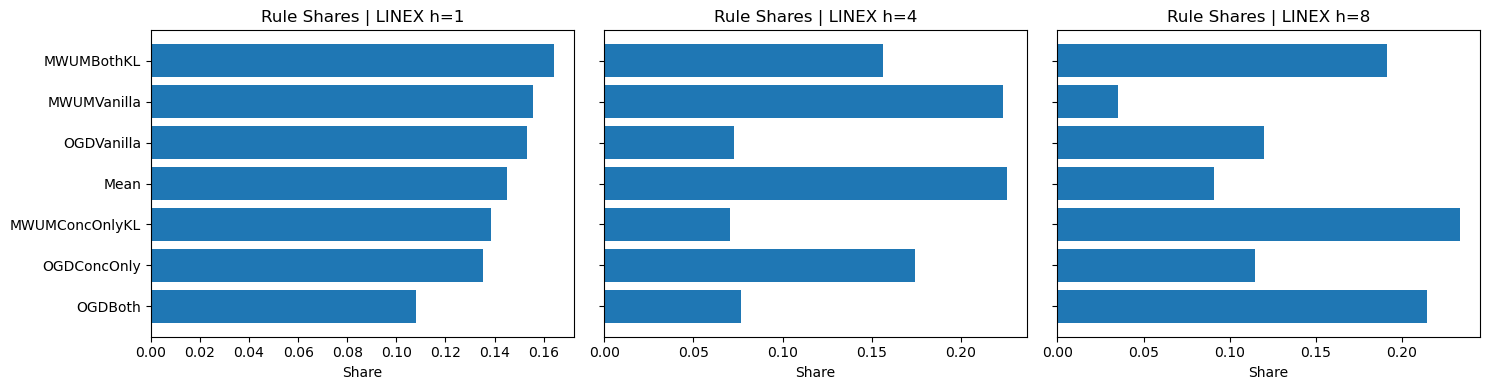

In [8]:
rule_diag = diag_df[diag_df['method'] == 'RLRuleBandit'].copy()
if not rule_diag.empty:
    shares = (
        rule_diag.groupby(['loss_section', 'horizon', 'action_name'])
        .size()
        .reset_index(name='count')
    )
    shares['share'] = shares.groupby(['loss_section', 'horizon'])['count'].transform(lambda x: x / x.sum())

    for loss_section in ['mse', 'linex']:
        fig, axes = plt.subplots(1, len(HORIZONS), figsize=(5 * len(HORIZONS), 4), sharey=True)
        if len(HORIZONS) == 1:
            axes = [axes]
        for ax, h in zip(axes, HORIZONS):
            sub = shares[(shares['loss_section'] == loss_section) & (shares['horizon'] == float(h))].sort_values('share')
            ax.barh(sub['action_name'], sub['share'])
            ax.set_title(f'Rule Shares | {loss_section.upper()} h={h}')
            ax.set_xlabel('Share')
        plt.tight_layout()
        plt.show()
else:
    print('No rule-bandit diagnostics available.')


## RL Diagnostics: Kappa Trajectory (Example Seed/Horizon)


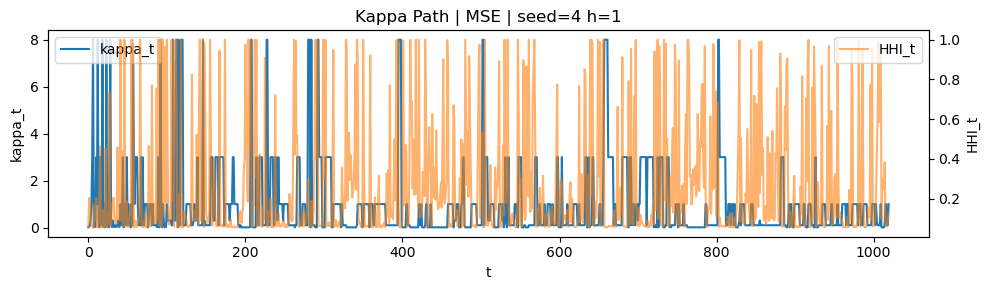

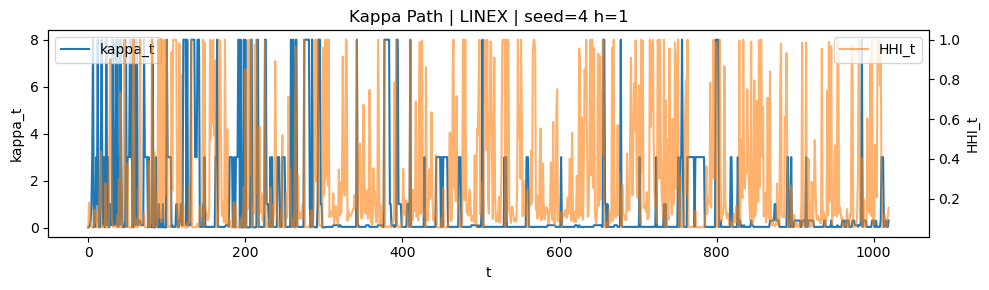

In [9]:
kdiag = diag_df[diag_df['method'] == 'RLKappaBandit'].copy()
if not kdiag.empty:
    for loss_section in ['mse', 'linex']:
        seed0 = float(TEST_SEEDS[0])
        h0 = float(HORIZONS[0])
        sub = kdiag[(kdiag['loss_section'] == loss_section) & (kdiag['seed'] == seed0) & (kdiag['horizon'] == h0)]

        fig, ax1 = plt.subplots(figsize=(10, 3))
        ax1.plot(sub['t'], sub['kappa'], label='kappa_t')
        ax1.set_title(f'Kappa Path | {loss_section.upper()} | seed={int(seed0)} h={int(h0)}')
        ax1.set_xlabel('t')
        ax1.set_ylabel('kappa_t')
        ax1.legend(loc='upper left')

        ax2 = ax1.twinx()
        ax2.plot(sub['t'], sub['hhi_t'], color='tab:orange', alpha=0.6, label='HHI_t')
        ax2.set_ylabel('HHI_t')
        ax2.legend(loc='upper right')
        plt.tight_layout()
        plt.show()
else:
    print('No kappa-bandit diagnostics available.')


## Plot: HHI Over Time vs Uncertainty State

This section rebuilds per-time weights for each method on a selected `(loss, seed, horizon)`, overlays uncertainty state, and shows `corr(state, HHI)` in the top-right of each panel.


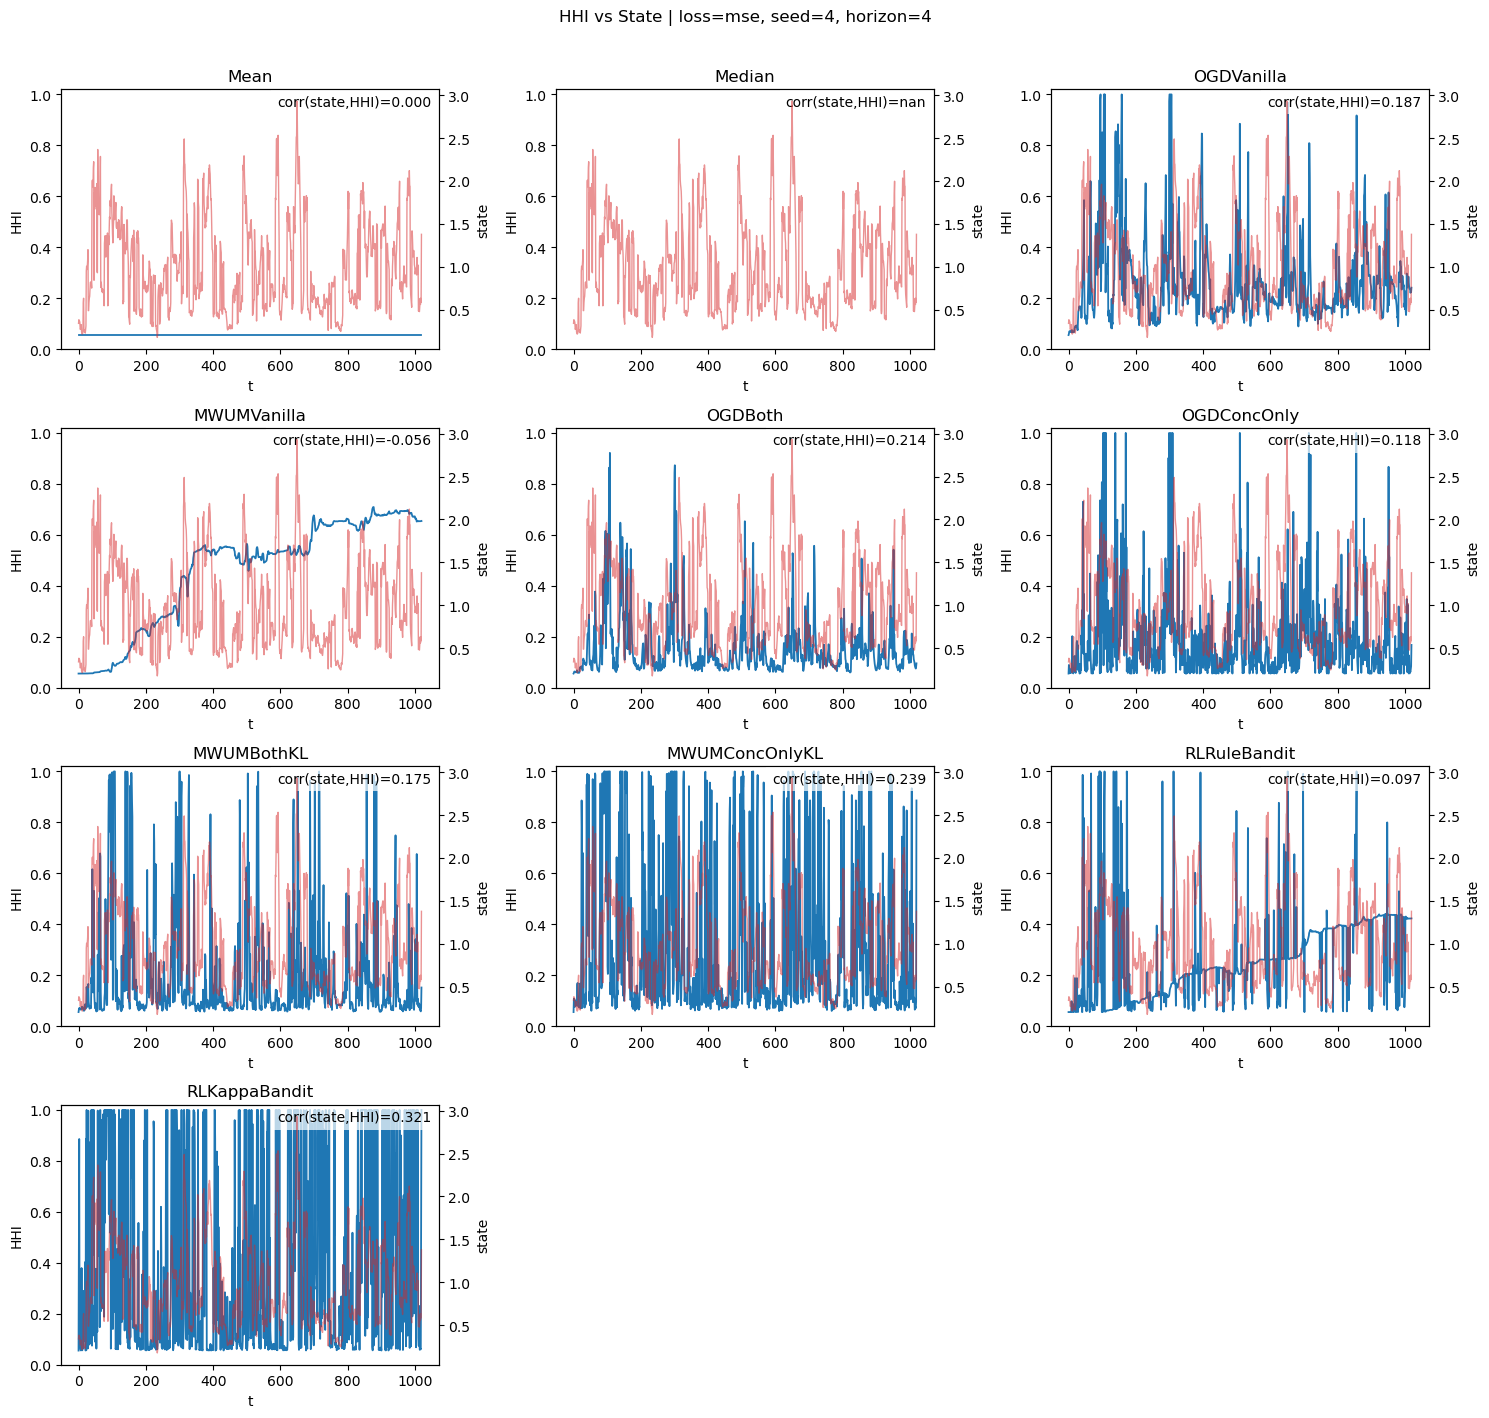

In [10]:
import math

def plot_hhi_state_overlay(loss_section='mse', seed=None, horizon=None):
    if seed is None:
        seed = int(TEST_SEEDS[0])
    if horizon is None:
        horizon = int(HORIZONS[0])

    data, forecasts_by_h, _, s_unc = runner.simulator.make_environment_and_forecasts(
        T=T, horizons=HORIZONS, window=WINDOW, seed=seed, include_oracle=False, scenario=SCENARIO
    )
    y, F, s = runner.align_for_horizon(data['pi'], forecasts_by_h[horizon], s_unc, horizon)
    X = runner.build_context(F, s)

    params_map = tuned_by_loss_h[loss_section][horizon]
    models = runner.build_models(params_map, loss_name=loss_section, linex_a=LINEX_A)

    hhi_by_method = {}
    for name, model in models.items():
        needs_state = name in runner.ot.STATE_METHODS
        res = model.run(F, y, s=s if needs_state else None)
        W = np.asarray(res.weights, dtype=float)
        hhi_by_method[name] = np.sum(W**2, axis=1)

    rl_loss = 'linex' if loss_section == 'linex' else 'mse'

    rule_bandit = runner.RuleSelectionBandit(
        n_forecasters=F.shape[1],
        context_dim=X.shape[1],
        alpha=0.5,
        action_specs=runner.tuned_rule_action_specs(params_map),
        loss=rl_loss,
        linex_a=LINEX_A,
        state_smoothing=runner.ot.DEFAULT_STATE_SMOOTHING,
        lambda_min=runner.ot.DEFAULT_LAMBDA_MIN,
    )
    rule_res = rule_bandit.run(F=F, y=y, X=X, s=s)
    hhi_by_method['RLRuleBandit'] = np.asarray(rule_res.hhi_t, dtype=float)

    kappa_bandit = runner.KappaBandit(
        kappa_grid=KAPPA_GRID,
        context_dim=X.shape[1],
        alpha=0.5,
        loss=rl_loss,
        linex_a=LINEX_A,
        state_smoothing=runner.ot.DEFAULT_STATE_SMOOTHING,
        lambda_min=runner.ot.DEFAULT_LAMBDA_MIN,
    )
    kappa_res = kappa_bandit.run(F=F, y=y, X=X, s=s)
    hhi_by_method['RLKappaBandit'] = np.asarray(kappa_res.hhi_t, dtype=float)

    names = list(hhi_by_method.keys())
    n = len(names)
    cols = 3
    rows = int(np.ceil(n / cols))

    t = np.arange(len(s))
    fig, axes = plt.subplots(rows, cols, figsize=(5 * cols, 3.5 * rows), squeeze=False)

    for i, name in enumerate(names):
        ax = axes[i // cols, i % cols]
        hhi = np.asarray(hhi_by_method[name], dtype=float)
        valid = np.isfinite(hhi) & np.isfinite(s)

        ax.plot(t, hhi, color='tab:blue', lw=1.3)
        ax.set_ylim(0.0, 1.02)
        ax.set_xlabel('t')
        ax.set_ylabel('HHI')

        ax2 = ax.twinx()
        ax2.plot(t, s, color='tab:red', lw=1.0, alpha=0.5)
        ax2.set_ylabel('state')

        corr = float(np.corrcoef(hhi[valid], s[valid])[0, 1]) if np.sum(valid) > 2 else math.nan
        ax.text(
            0.98, 0.98, f'corr(state,HHI)={corr:.3f}',
            transform=ax.transAxes, ha='right', va='top',
            bbox=dict(facecolor='white', alpha=0.7, edgecolor='none')
        )
        ax.set_title(name)

    for j in range(n, rows * cols):
        axes[j // cols, j % cols].axis('off')

    fig.suptitle(f'HHI vs State | loss={loss_section}, seed={seed}, horizon={horizon}', y=1.01)
    fig.tight_layout()
    plt.show()


PLOT_LOSS = 'mse'
PLOT_SEED = int(TEST_SEEDS[0])
PLOT_H = int(HORIZONS[1] if len(HORIZONS) > 1 else HORIZONS[0])
plot_hhi_state_overlay(loss_section=PLOT_LOSS, seed=PLOT_SEED, horizon=PLOT_H)


## Lagged Correlation Check (state_t -> HHI_{t+1})

Computes per-method average lagged correlations across test seeds/horizons for both loss sections.


In [ ]:
def _corr(a, b):
    a = np.asarray(a, dtype=float)
    b = np.asarray(b, dtype=float)
    m = np.isfinite(a) & np.isfinite(b)
    if np.sum(m) < 3:
        return np.nan
    aa = a[m]
    bb = b[m]
    if np.std(aa) < 1e-12 or np.std(bb) < 1e-12:
        return np.nan
    return float(np.corrcoef(aa, bb)[0, 1])

rows = []
for loss_section in ['mse', 'linex']:
    for seed in TEST_SEEDS:
        data, forecasts_by_h, _, s_unc = runner.simulator.make_environment_and_forecasts(
            T=T, horizons=HORIZONS, window=WINDOW, seed=seed, include_oracle=False, scenario=SCENARIO
        )
        for h in HORIZONS:
            y, F, s = runner.align_for_horizon(data['pi'], forecasts_by_h[h], s_unc, h)
            X = runner.build_context(F, s)
            params_map = tuned_by_loss_h[loss_section][h]

            models = runner.build_models(params_map, loss_name=loss_section, linex_a=LINEX_A)
            for name, model in models.items():
                needs_state = name in runner.ot.STATE_METHODS
                res = model.run(F, y, s=s if needs_state else None)
                hhi = np.sum(np.asarray(res.weights, dtype=float) ** 2, axis=1)
                c_same = _corr(s, hhi)
                c_next = _corr(s[:-1], hhi[1:]) if len(hhi) > 1 else np.nan
                lam = np.asarray(res.meta.get('lambda', np.full_like(hhi, np.nan)), dtype=float)
                c_lam_next = _corr(lam[:-1], hhi[1:]) if len(hhi) > 1 else np.nan
                rows.append({'loss_section': loss_section, 'seed': seed, 'horizon': h, 'method': name, 'corr_state_same': c_same, 'corr_state_next': c_next, 'corr_lambda_next': c_lam_next})

            rl_loss = 'linex' if loss_section == 'linex' else 'mse'
            rb = runner.RuleSelectionBandit(
                n_forecasters=F.shape[1], context_dim=X.shape[1], alpha=0.5,
                action_specs=runner.tuned_rule_action_specs(params_map),
                loss=rl_loss, linex_a=LINEX_A,
                state_smoothing=runner.ot.DEFAULT_STATE_SMOOTHING,
                lambda_min=runner.ot.DEFAULT_LAMBDA_MIN,
            )
            rr = rb.run(F=F, y=y, X=X, s=s)
            hhi = np.asarray(rr.hhi_t, dtype=float)
            rows.append({'loss_section': loss_section, 'seed': seed, 'horizon': h, 'method': 'RLRuleBandit', 'corr_state_same': _corr(s, hhi), 'corr_state_next': _corr(s[:-1], hhi[1:]) if len(hhi) > 1 else np.nan, 'corr_lambda_next': np.nan})

            kb = runner.KappaBandit(
                kappa_grid=KAPPA_GRID, context_dim=X.shape[1], alpha=0.5,
                loss=rl_loss, linex_a=LINEX_A,
                state_smoothing=runner.ot.DEFAULT_STATE_SMOOTHING,
                lambda_min=runner.ot.DEFAULT_LAMBDA_MIN,
            )
            kr = kb.run(F=F, y=y, X=X, s=s)
            hhi = np.asarray(kr.hhi_t, dtype=float)
            lam = np.asarray(kr.meta.get('lambda_t', np.full_like(hhi, np.nan)), dtype=float)
            rows.append({'loss_section': loss_section, 'seed': seed, 'horizon': h, 'method': 'RLKappaBandit', 'corr_state_same': _corr(s, hhi), 'corr_state_next': _corr(s[:-1], hhi[1:]) if len(hhi) > 1 else np.nan, 'corr_lambda_next': _corr(lam[:-1], hhi[1:]) if len(hhi) > 1 else np.nan})

lag_df = pd.DataFrame(rows)
lag_summary = lag_df.groupby(['loss_section', 'method'], as_index=False)[['corr_state_same', 'corr_state_next', 'corr_lambda_next']].mean()
display(lag_summary.sort_values(['loss_section', 'method']).reset_index(drop=True))


,loss_section,method,corr_state_same,corr_state_next,corr_lambda_next
0,linex,MWUMBothKL,0.091903,0.091760,0.104166
1,linex,MWUMConcOnlyKL,0.065771,0.097032,0.070618
2,linex,MWUMVanilla,0.017085,0.021293,NaN
3,linex,Mean,NaN,NaN,NaN
4,linex,Median,NaN,NaN,NaN
5,linex,OGDBoth,0.117424,0.127526,0.141548
6,linex,OGDConcOnly,0.080061,0.120240,0.087563
7,linex,OGDVanilla,0.108653,0.123231,NaN
8,linex,RLKappaBandit,0.157261,0.175033,-0.352962
9,linex,RLRuleBandit,0.058262,0.051625,NaN


In [1]:
# 40-simulation rerun + HHI vs improvement plots (separate output set)
import os
import sys
import subprocess
from pathlib import Path

def find_project_root(start: Path) -> Path:
    for p in [start, *start.parents]:
        if (p / 'src').exists() and (p / 'src' / 'evaluation' / 'dual_loss_with_rl.py').exists():
            return p
    raise RuntimeError('Could not locate project root from notebook cwd')

ROOT = find_project_root(Path.cwd().resolve())
script = ROOT / 'src' / 'evaluation' / 'dual_loss_with_rl.py'
tuned_csv = ROOT / 'analyses' / 'results' / 'dual_loss_full_tuned_params.csv'
out_dir = ROOT / 'analyses' / 'results' / 'multi_sim_40'
out_dir.mkdir(parents=True, exist_ok=True)
scenario = globals().get('SCENARIO', 'discriminating')
output_stem = 'dual_loss_multi40'

cmd = [
    sys.executable,
    str(script),
    '--scenario', str(scenario),
    '--skip-tuning',
    '--tuned-params-csv', str(tuned_csv),
    '--n-test-sims', '40',
    '--test-seed-start', '4',
    '--out-dir', str(out_dir),
    '--output-stem', output_stem,
]
env = os.environ.copy()
prev = env.get('PYTHONPATH', '')
env['PYTHONPATH'] = str(ROOT) if not prev else str(ROOT) + os.pathsep + prev
print('Running:', ' '.join(cmd))
subprocess.run(cmd, check=True, env=env, cwd=str(ROOT))


Running: /home/clayt/miniconda3/envs/ensemble/bin/python /home/clayt/Ensemble-Forecasting/src/evaluation/dual_loss_with_rl.py --scenario discriminating --skip-tuning --tuned-params-csv /home/clayt/Ensemble-Forecasting/analyses/results/dual_loss_full_tuned_params.csv --n-test-sims 40 --test-seed-start 4 --out-dir /home/clayt/Ensemble-Forecasting/analyses/results/multi_sim_40 --output-stem dual_loss_multi40
Using tuned params from: /home/clayt/Ensemble-Forecasting/analyses/results/dual_loss_full_tuned_params.csv
Wrote: /home/clayt/Ensemble-Forecasting/analyses/results/multi_sim_40/dual_loss_multi40_detailed.csv
Wrote: /home/clayt/Ensemble-Forecasting/analyses/results/multi_sim_40/dual_loss_multi40_summary.csv
Wrote: /home/clayt/Ensemble-Forecasting/analyses/results/multi_sim_40/dual_loss_multi40_tuned_params.csv
Wrote: /home/clayt/Ensemble-Forecasting/analyses/results/multi_sim_40/dual_loss_multi40_policy_diagnostics.csv
Wrote: /home/clayt/Ensemble-Forecasting/analyses/results/multi_sim_

CompletedProcess(args=['/home/clayt/miniconda3/envs/ensemble/bin/python', '/home/clayt/Ensemble-Forecasting/src/evaluation/dual_loss_with_rl.py', '--scenario', 'discriminating', '--skip-tuning', '--tuned-params-csv', '/home/clayt/Ensemble-Forecasting/analyses/results/dual_loss_full_tuned_params.csv', '--n-test-sims', '40', '--test-seed-start', '4', '--out-dir', '/home/clayt/Ensemble-Forecasting/analyses/results/multi_sim_40', '--output-stem', 'dual_loss_multi40'], returncode=0)

,avg_excess_objective_vs_best_individual,avg_hhi_mean,avg_improvement_pct_vs_best_individual,avg_lambda_mean,diag_aux_mean,diag_main_mean,horizon,linex_mean,loss_section,mae_mean,method,mse_mean,objective_mean,objective_std
0,0.215986,0.055556,-18.204121,NaN,NaN,NaN,1.0,1.061127,linex,0.652161,Mean,0.908882,1.061127,1.103452
1,0.290542,0.062515,-19.668191,NaN,NaN,NaN,1.0,1.135682,linex,0.645169,MWUMVanilla,0.901285,1.135682,1.516395
2,0.295876,NaN,-21.895467,NaN,NaN,NaN,1.0,1.141017,linex,0.637816,Median,0.896557,1.141017,1.397920
3,1.012959,0.144582,-73.415492,NaN,NaN,NaN,1.0,1.858100,linex,0.678169,OGDVanilla,0.966914,1.858100,5.545110
4,1.015300,0.142885,-73.504211,0.002483,NaN,NaN,1.0,1.860441,linex,0.677915,OGDBoth,0.966294,1.860441,5.545729
5,1.053897,0.940602,-68.347343,0.000779,NaN,NaN,1.0,1.899038,linex,0.696805,MWUMBothKL,0.992463,1.899038,5.521594
6,1.062476,0.191311,-76.739786,NaN,0.372843,3.150000,1.0,1.907616,linex,0.658402,RLRuleBandit,0.937493,1.907616,5.561875
7,1.065911,0.058712,-76.196620,5.308534,NaN,NaN,1.0,1.911052,linex,0.647376,MWUMConcOnlyKL,0.916837,1.911052,5.540956
8,1.272220,0.197259,-100.811567,1.272453,0.565245,1.865361,1.0,2.117360,linex,0.662317,RLKappaBandit,0.988773,2.117360,5.568307
9,1.299037,0.084451,-103.194853,5.402617,NaN,NaN,1.0,2.144178,linex,0.658436,OGDConcOnly,0.967102,2.144178,6.768586


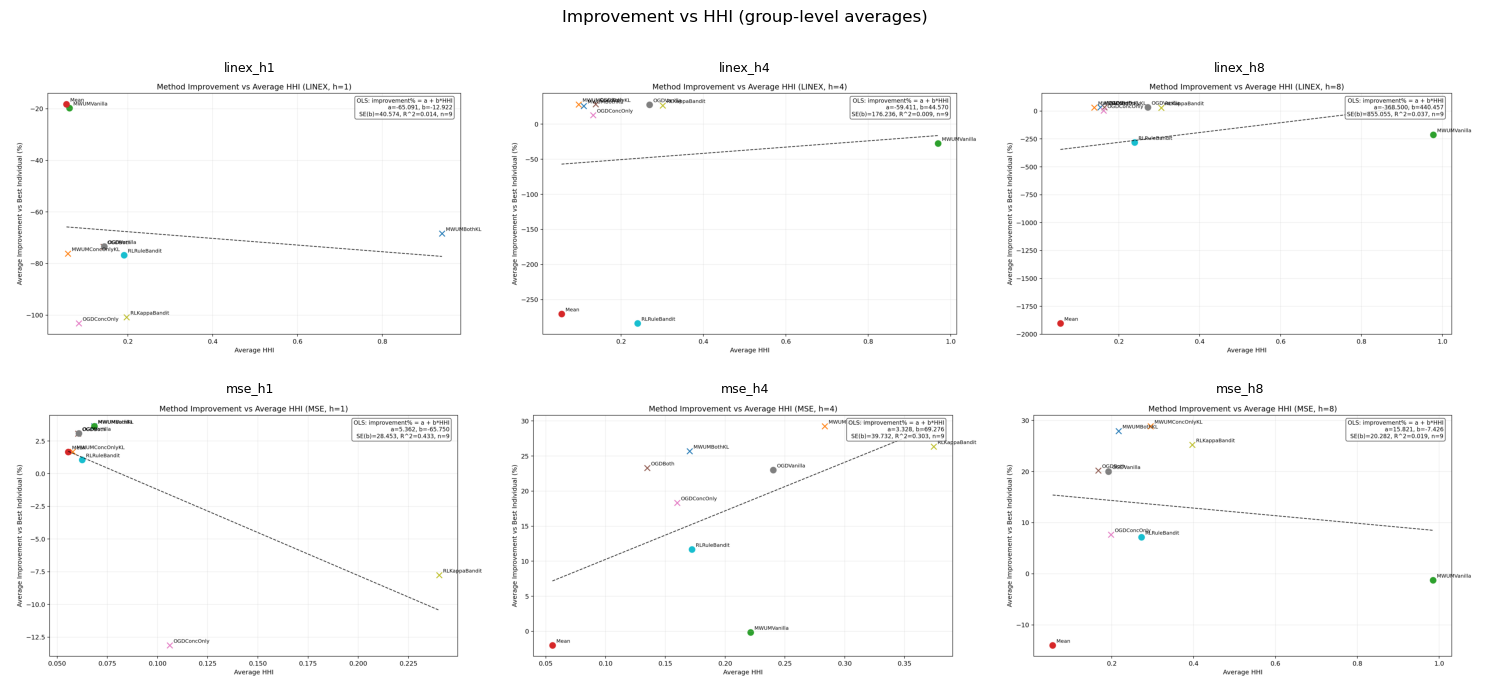

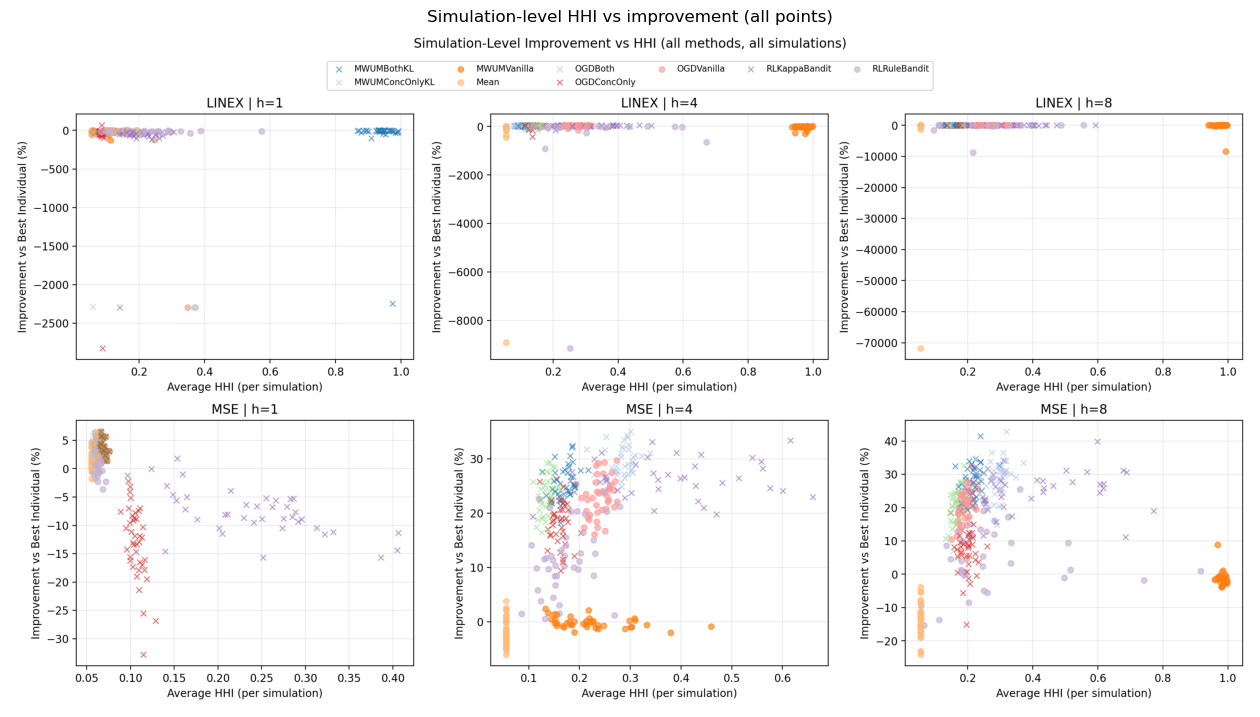

In [2]:
import math
from pathlib import Path

import matplotlib.pyplot as plt
import pandas as pd
from IPython.display import display

def find_project_root(start: Path) -> Path:
    for p in [start, *start.parents]:
        if (p / 'src').exists() and (p / 'analyses' / 'results').exists():
            return p
    raise RuntimeError('Could not locate project root from notebook cwd')

ROOT = globals().get('ROOT', find_project_root(Path.cwd().resolve()))
out_dir = ROOT / 'analyses' / 'results' / 'multi_sim_40'
output_stem = 'dual_loss_multi40'

summary = pd.read_csv(out_dir / f'{output_stem}_summary.csv')
display(summary.sort_values(['loss_section', 'horizon', 'objective_mean']).reset_index(drop=True))

plot_files = sorted(out_dir.glob(f'{output_stem}_improvement_vs_hhi_*.png'))
if not plot_files:
    print('No per-group improvement-vs-HHI files found in', out_dir)
else:
    n = len(plot_files)
    cols = min(3, n)
    rows = math.ceil(n / cols)
    fig, axes = plt.subplots(rows, cols, figsize=(5 * cols, 3.6 * rows), squeeze=False)
    flat = axes.ravel()

    for ax, p in zip(flat, plot_files):
        img = plt.imread(p)
        ax.imshow(img)
        ax.set_title(p.stem.replace(f'{output_stem}_improvement_vs_hhi_', ''), fontsize=9)
        ax.axis('off')

    for ax in flat[n:]:
        ax.axis('off')

    fig.suptitle('Improvement vs HHI (group-level averages)', y=0.995)
    fig.tight_layout()
    plt.show()

indiv_plot = out_dir / f'{output_stem}_individual_improvement_vs_hhi.png'
if indiv_plot.exists():
    fig = plt.figure(figsize=(16, 10))
    img = plt.imread(indiv_plot)
    plt.imshow(img)
    plt.axis('off')
    plt.title('Simulation-level HHI vs improvement (all points)')
    plt.show()
else:
    print('Missing simulation-level plot:', indiv_plot)
